In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from my_functions import *
from scipy.stats import *
import plotly.express as px
import plotly.graph_objects as go

sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import f_classif, SelectFpr, chi2, SelectKBest, SelectFdr
from sklearn.ensemble import IsolationForest
from sklearn.metrics import *
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
import pickle
import re

np.random.seed(42)

# Eda
## Importing files

In [2]:
# I import test and train dataframes
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_ls = [df_train, df_test]
df_train

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0                0   70172    Male     Loyal Customer   13  Personal Travel   
1                1    5047    Male  disloyal Customer   25  Business travel   
2                2  110028  Female     Loyal Customer   26  Business travel   
3                3   24026  Female     Loyal Customer   25  Business travel   
4                4  119299    Male     Loyal Customer   61  Business travel   
...            ...     ...     ...                ...  ...              ...   
103899      103899   94171  Female  disloyal Customer   23  Business travel   
103900      103900   73097    Male     Loyal Customer   49  Business travel   
103901      103901   68825    Male  disloyal Customer   30  Business travel   
103902      103902   54173  Female  disloyal Customer   22  Business travel   
103903      103903   62567    Male     Loyal Customer   27  Business travel   

           Class  Flight Distance  Inflight wifi service  \
0       Eco Plus              460                      3   
1       Business              235                      3   
2       Business             1142                      2   
3       Business              562                      2   
4       Business              214                      3   
...          ...              ...                    ...   
103899       Eco              192                      2   
103900  Business             2347                      4   
103901  Business             1995                      1   
103902       Eco             1000                      1   
103903  Business             1723                      1   

        Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                       4  ...                       5   
1                                       2  ...                       1   
2                                       2  ...                       5   
3                                       5  ...                       2   
4                                       3  ...                       3   
...                                   ...  ...                     ...   
103899                                  1  ...                       2   
103900                                  4  ...                       5   
103901                                  1  ...                       4   
103902                                  1  ...                       1   
103903                                  3  ...                       1   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                      4                 3                 4                4   
1                      1                 5                 3                1   
2                      4                 3                 4                4   
3                      2                 5                 3                1   
4                      3                 4                 4                3   
...                  ...               ...               ...              ...   
103899                 3                 1                 4                2   
103900                 5                 5                 5                5   
103901                 3                 2                 4                5   
103902                 4                 5                 1                5   
103903                 1                 1                 4                4   

        Inflight service  Cleanliness  Departure Delay in Minutes  \
0                      5            5                          25   
1                      4            1                           1   
2                      4            5                           0   
3                      4            2                          11   
4                      3            3                           0   
...                  ...          ...                         

Importing the data frames, I can immediately observe that we are in a binary classification problem.

### Remapping the target column

In [3]:
# I remap the results by paying attention that no data leaking occurs
mapper = {'neutral or dissatisfied': 0, 'satisfied': 1}
for df in df_ls:
    df["satisfaction"] = df["satisfaction"].replace(mapper)
df_train.head()

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                                  2  ...                       5   
3                                  5  ...                       2   
4                                  3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes  satisfaction  
0                      18.0             0  
1                       6.0             0  
2                       0.0             1  
3                       9.0             0  
4                       0.0             1  

[5 rows x 25 columns]

### Removing superfluous columns

In [4]:
col_to_drop = ["Unnamed: 0", "id"]
for df in df_ls:
    df.drop(columns=col_to_drop, inplace=True)

df_train.head()

Gender      Customer Type  Age   Type of Travel     Class  Flight Distance  \
0    Male     Loyal Customer   13  Personal Travel  Eco Plus              460   
1    Male  disloyal Customer   25  Business travel  Business              235   
2  Female     Loyal Customer   26  Business travel  Business             1142   
3  Female     Loyal Customer   25  Business travel  Business              562   
4    Male     Loyal Customer   61  Business travel  Business              214   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      3                                  4   
1                      3                                  2   
2                      2                                  2   
3                      2                                  5   
4                      3                                  3   

   Ease of Online booking  Gate location  ...  Inflight entertainment  \
0                       3              1  ...                       5   
1                       3              3  ...                       1   
2                       2              2  ...                       5   
3                       5              5  ...                       2   
4                       3              3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes  satisfaction  
0                      18.0             0  
1                       6.0             0  
2                       0.0             1  
3                       9.0             0  
4                       0.0             1  

[5 rows x 23 columns]

### I create Train and Test set

In [5]:
X_train, y_train = df_train.drop(
    columns="satisfaction"), df_train["satisfaction"]
X_test, y_test = df_test.drop(columns="satisfaction"), df_test["satisfaction"]

## Research and replacement of NaN

In [6]:
for df in [X_train, X_test]:
    print(df.isnull().values.any())

True
True


From the output of this for loop, we understand that null values are present and must be replaced.

In [7]:
nan = find_nan_col([X_train, X_test])
nan

['Arrival Delay in Minutes']

In [1]:
# I replaced the missing values with the median of the column in which they are found
for df in [X_train, X_test]:
    df[nan] = df[nan].fillna(df[nan].median())

NameError: name 'X_train' is not defined

I chose to replace missing values with the median. This is because, unlike the mean, the median is a robust value, thus little subject to outliers.

In [9]:
# I verify the correct replacement
for df in [X_train, X_test]:
    print(df.isnull().values.any())

False
False


## Dummy encoding
New columns will be created whose names reflect those of the variables of the different categorical features. In particular, I decided to use this encoding since I think it is easier to understand.

When a passenger has a specific categorical feature within the data frame, it will appear as 1, otherwise 0.

In [10]:
# Creation of a list of dataframes containing dummy featurs
dummy_df = []
for df in [X_train, X_test]:
    # This function will leave all columns with non-categorical data untouched
    z = pd.get_dummies(data=df, prefix_sep="_")
    dummy_df.append(z)

In [11]:
X_train = dummy_df[0].copy()
X_test = dummy_df[1].copy()

In [12]:
X_train

Age  Flight Distance  Inflight wifi service  \
0        13              460                      3   
1        25              235                      3   
2        26             1142                      2   
3        25              562                      2   
4        61              214                      3   
...     ...              ...                    ...   
103899   23              192                      2   
103900   49             2347                      4   
103901   30             1995                      1   
103902   22             1000                      1   
103903   27             1723                      1   

        Departure/Arrival time convenient  Ease of Online booking  \
0                                       4                       3   
1                                       2                       3   
2                                       2                       2   
3                                       5                       5   
4                                       3                       3   
...                                   ...                     ...   
103899                                  1                       2   
103900                                  4                       4   
103901                                  1                       1   
103902                                  1                       1   
103903                                  3                       3   

        Gate location  Food and drink  Online boarding  Seat comfort  \
0                   1               5                3             5   
1                   3               1                3             1   
2                   2               5                5             5   
3                   5               2                2             2   
4                   3               4                5             5   
...               ...             ...              ...           ...   
103899              3               2                2             2   
103900              4               2                4             5   
103901              3               4                1             5   
103902              5               1                1             1   
103903              3               1                1             1   

        Inflight entertainment  ...  Arrival Delay in Minutes  Gender_Female  \
0                            5  ...                      18.0              0   
1                            1  ...                       6.0              0   
2                            5  ...                       0.0              1   
3                            2  ...                       9.0              1   
4                            3  ...                       0.0              0   
...                        ...  ...                       ...            ...   
103899                       2  ...                       0.0              1   
103900                       5  ...                       0.0              0   
103901                       4  ...                      14.0              0   
103902                       1  ...                       0.0              1   
103903                       1  ...                       0.0              0   

        Gender_Male  Customer Type_Loyal Customer  \
0                 1                             1   
1                 1                             0   
2                 0                             1   
3                 0                             1   
4                 1                             1   
...             ...                           ...   
103899            0                             0   
103900            1                             1   
103901            1                             0   
103902            0                             0   
103903            1                             1   

        Customer Type_disloyal Customer  Type of Travel

## Standardization & Normalization
These steps are critical. Some algorithms, like KNN, prefer scaled data frames to do the fit.

I also decided to use normalization because I get values between zero minimum and one maximum. Positive values are fundamental for the Chi2 test.

In [13]:
X_col = X_train.columns

In [14]:
# I apply the standard scaler
stnd = []
for x in [X_train, X_test]:
    sc = StandardScaler().fit_transform(x)
    stnd.append(sc)
# I apply normalization
normalized = []
for z in stnd:
    mms = MinMaxScaler().fit_transform(z)
    normalized.append(mms)

In [15]:
# I assign the new values to the starting dataframes
X_train = pd.DataFrame(data=normalized[0], columns=X_col)
X_test = pd.DataFrame(data=normalized[1], columns=X_col)

In [16]:
# I create baseline models before removing some features and values to compare them with other models
X_train_baseline, X_test_baseline = X_train.copy(), X_test.copy()
y_train_baseline, y_test_baseline = y_train.copy(), y_test.copy()
# I check the number of features in each.
print(X_train_baseline.shape[1], X_test_baseline.shape[1])

27 27


## Analysis of outliers & Balancing.
In this part, I will evaluate the distribution and quantity of outliers in the trainset.

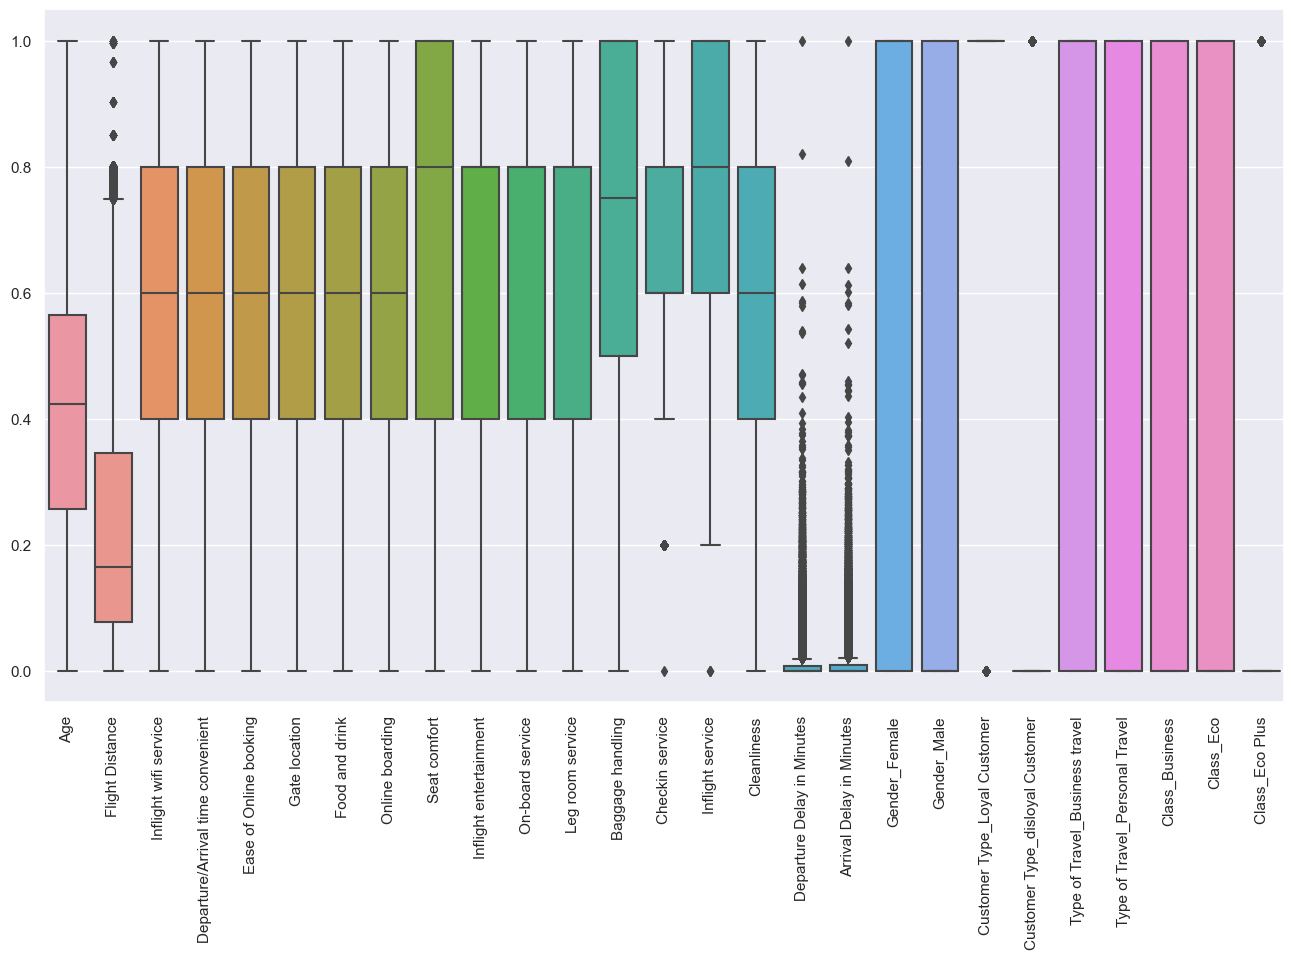

In [17]:
plt.figure(figsize=(16, 9))
plt.xticks(rotation=90)
sns.boxplot(data=X_train)
plt.show()

As we can observe, the starting situation is not the best. There are a lot of outliers (identified with black dots).

The features with the most id outliers are "Departures Delay in Minutes" and "Arrival Delay in Minutes."

Furthermore, these two features have very similar outliers; this is easily explained by the fact that if an airplane is delayed on departure, it will most likely be delayed on arrival as well.

In [18]:
# Contamination factor used to select the portion of the dataset to be discarded
contamin = 0.2
# Algorithms for the selection and subsequent removal of outliers
iso = IsolationForest(n_jobs=-1, random_state=42, contamination=contamin)
lof = LocalOutlierFactor(n_jobs=-1, contamination=contamin)

In [19]:
od_performance = []
for idx, outlier_detector in enumerate([iso, lof]):
    # This step was obscured to avoid re-training the model continuously

    #yhat = outlier_detector.fit_predict(X_train)
    #pickle.dump(yhat,open(f"file/outliers{idx+1}.pkl","wb"))

    # I import the trained model
    yhat = pickle.load(open(f"file/outliers{idx+1}.pkl", "rb"))
    # I create a mask
    mask = yhat != -1
    # I apply the mask and assign the value to the new dataframes
    X_train_ro, y_train_ro = X_train[mask], y_train[mask]
    # Calculating the number of romossi elements
    size_reduction = X_train.shape[0] - X_train_ro.shape[0]
    # I will add to the support list
    od_performance.append([X_train_ro, y_train_ro, size_reduction])

20781 outliers were removed


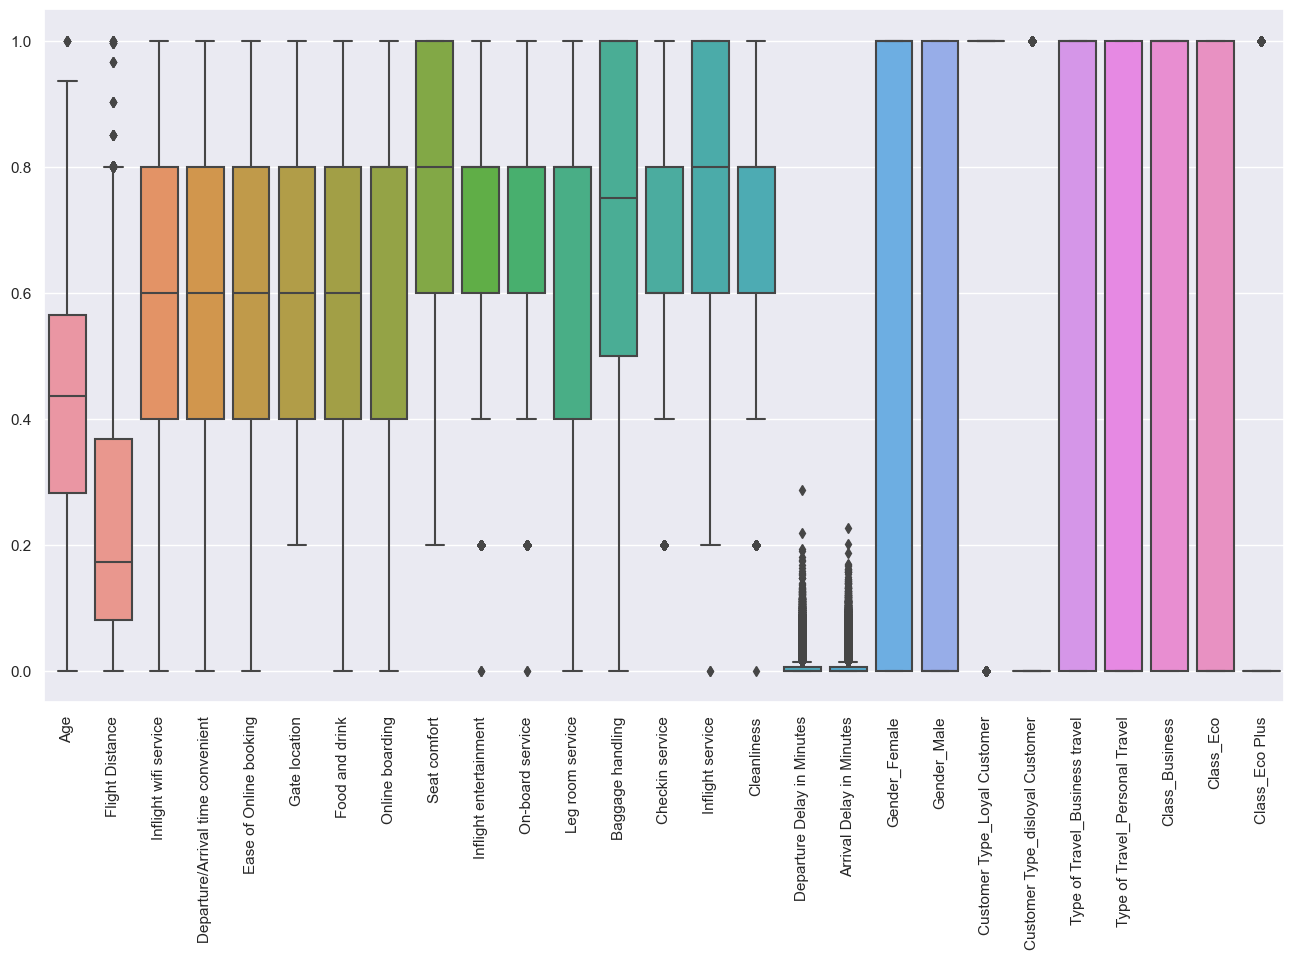

20781 outliers were removed


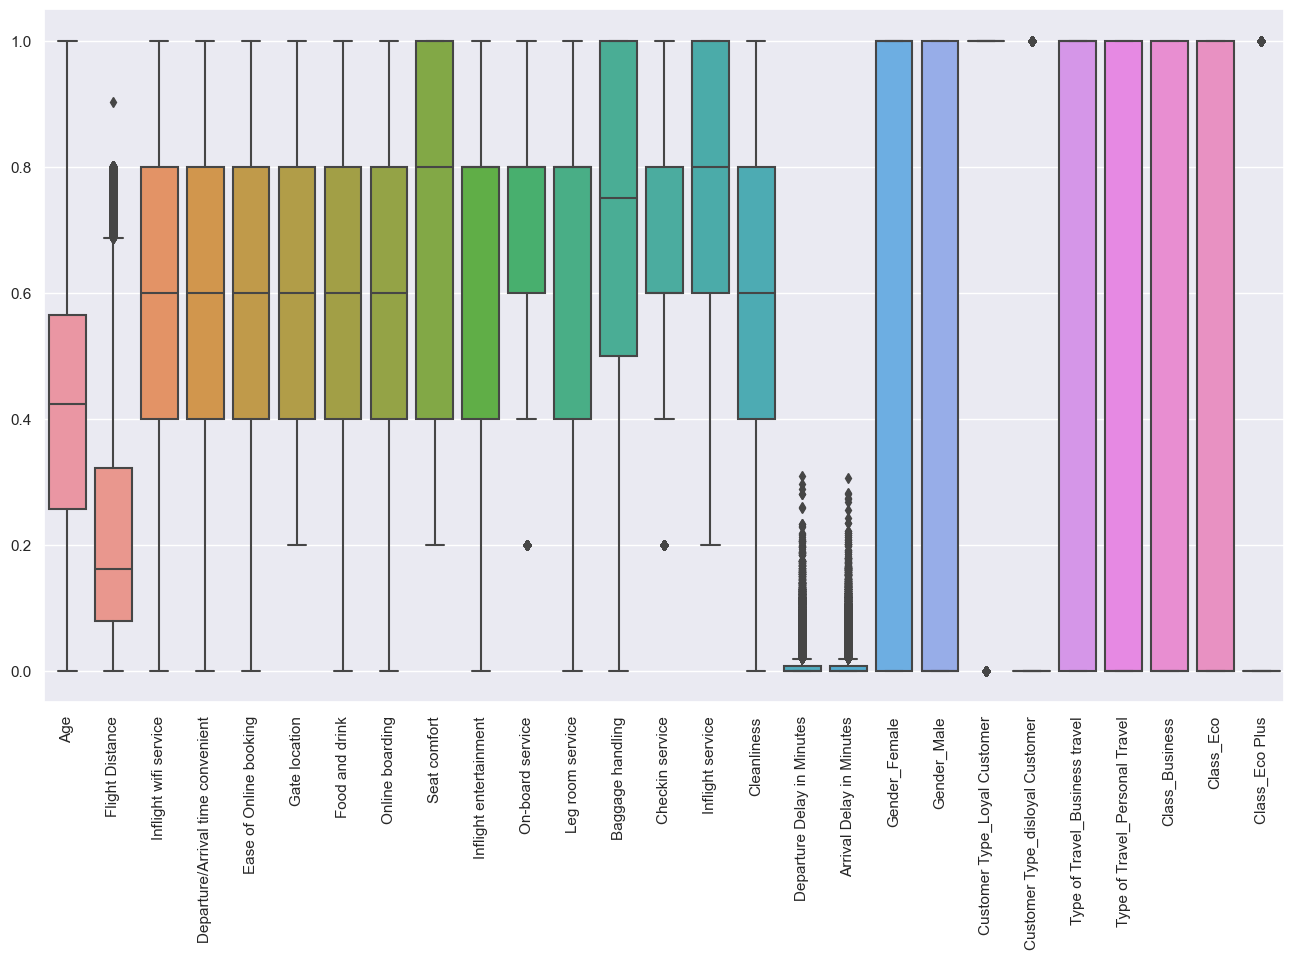

In [20]:
# I graphically evaluate the result of the two outliers removal algorithms on the train set
for X, y, size_reduction in od_performance:
    print(f"{size_reduction} outliers were removed")
    plt.figure(figsize=(16, 9))
    plt.xticks(rotation=90)
    sns.boxplot(data=X)
    plt.show()

As we can observe, both algorithms reduced the variance in the model; the best-performing one will be chosen.

In [21]:
X_train_iso = od_performance[0][0].reset_index(drop=True)
y_train_iso = od_performance[0][1].reset_index(drop=True)

X_train_lof = od_performance[1][0].reset_index(drop=True)
y_train_lof = od_performance[1][1].reset_index(drop=True)

out = [[X_train_iso, y_train_iso], [X_train_lof, y_train_lof]]

At this stage, the balance of the different datasets will be evaluated.

In particular, attention should be paid to the ratio of positive (Target = 1) to negative (Target = 0) observations.

Ideally, we would like to have a train with a ratio as close to 1 as possible; this would mean having as many positive outcomes as negative ones.

In [22]:
n = 0
for outlier_detector_method in out:
    tag = ["Isolation Forest", "Local Outlier Factor"]
    for X, y in [outlier_detector_method]:
        num_satisfied_train = (y == 1).sum()
        num_unsatisfied_train = (y == 0).sum()
        s_uns_ratio_train = (num_satisfied_train /
                             num_unsatisfied_train).round(3)
        train_dimension = X.shape[0]
        print(
            f"With the algorithm {tag[n]} the ratio of satisfied to non-satisfied in the train set {s_uns_ratio_train}",
            f"Train set dimensions: {train_dimension}")
        n = n + 1

With the algorithm Isolation Forest the ratio of satisfied to non-satisfied in the train set 0.874 Train set dimensions: 83123
With the algorithm Local Outlier Factor the ratio of satisfied to non-satisfied in the train set 0.701 Train set dimensions: 83123


In [23]:
print(f"{(y_train_iso==1).value_counts()}\n{(y_train_lof==1).value_counts()}")

False    44360
True     38763
Name: satisfaction, dtype: int64
False    48876
True     34247
Name: satisfaction, dtype: int64


As we can see with both outliers detection methods, we don't have a "satisfied" and "unsatisfied" ratio of 1, so I'm going to perform downsampling to have a balanced data frame.

In [24]:
# For cicle used to balance the train set to match to have ratio = 1
balanced_dfs = []
for outlier_detector_method in out:
    for X, y in [outlier_detector_method]:
        df_temp = pd.concat([X, y], axis=1)
        satisfied = df_temp[df_temp['satisfaction'] == 1]
        unsatisfied = df_temp[df_temp['satisfaction'] == 0]
        unsatisfied = unsatisfied.sample(n=len(satisfied), random_state=42)
        df_temp = pd.concat([satisfied, unsatisfied], axis=0)
        df_temp = df_temp.sample(frac=1,
                                 random_state=42).reset_index(drop=True)
        balanced_dfs.append(df_temp)

In [25]:
X_train_iso = balanced_dfs[0].drop(columns='satisfaction')
y_train_iso = balanced_dfs[0]['satisfaction']

X_train_lof = balanced_dfs[1].drop(columns='satisfaction')
y_train_lof = balanced_dfs[1]['satisfaction']

out = [[X_train_iso, y_train_iso], [X_train_lof, y_train_lof]]

In [26]:
iso_std = X_train_iso.describe().iloc[2].mean()
lof_std = X_train_lof.describe().iloc[2].mean()
difference = round(abs(iso_std - lof_std), 4)

if iso_std > lof_std:
    X_train = X_train_lof
    y_train = y_train_lof
    print(
        f"Std Iso > of Lof of: {difference} so the dataset with the least standard deviation across features is Local Outlier Factor."
    )
else:
    X_train = X_train_iso
    y_train = y_train_iso
    print(
        f"Std Lof > of Iso of: {difference} so the dataset with the least standard deviation across features is Isolation Forest."
    )

Std Lof > of Iso of: 0.0119 so the dataset with the least standard deviation across features is Isolation Forest.


Having evaluated the standard deviation between features, we can see that the Isolation forest algorithm did a better job removing outliers from the dataset.

## Correlation

<AxesSubplot:>

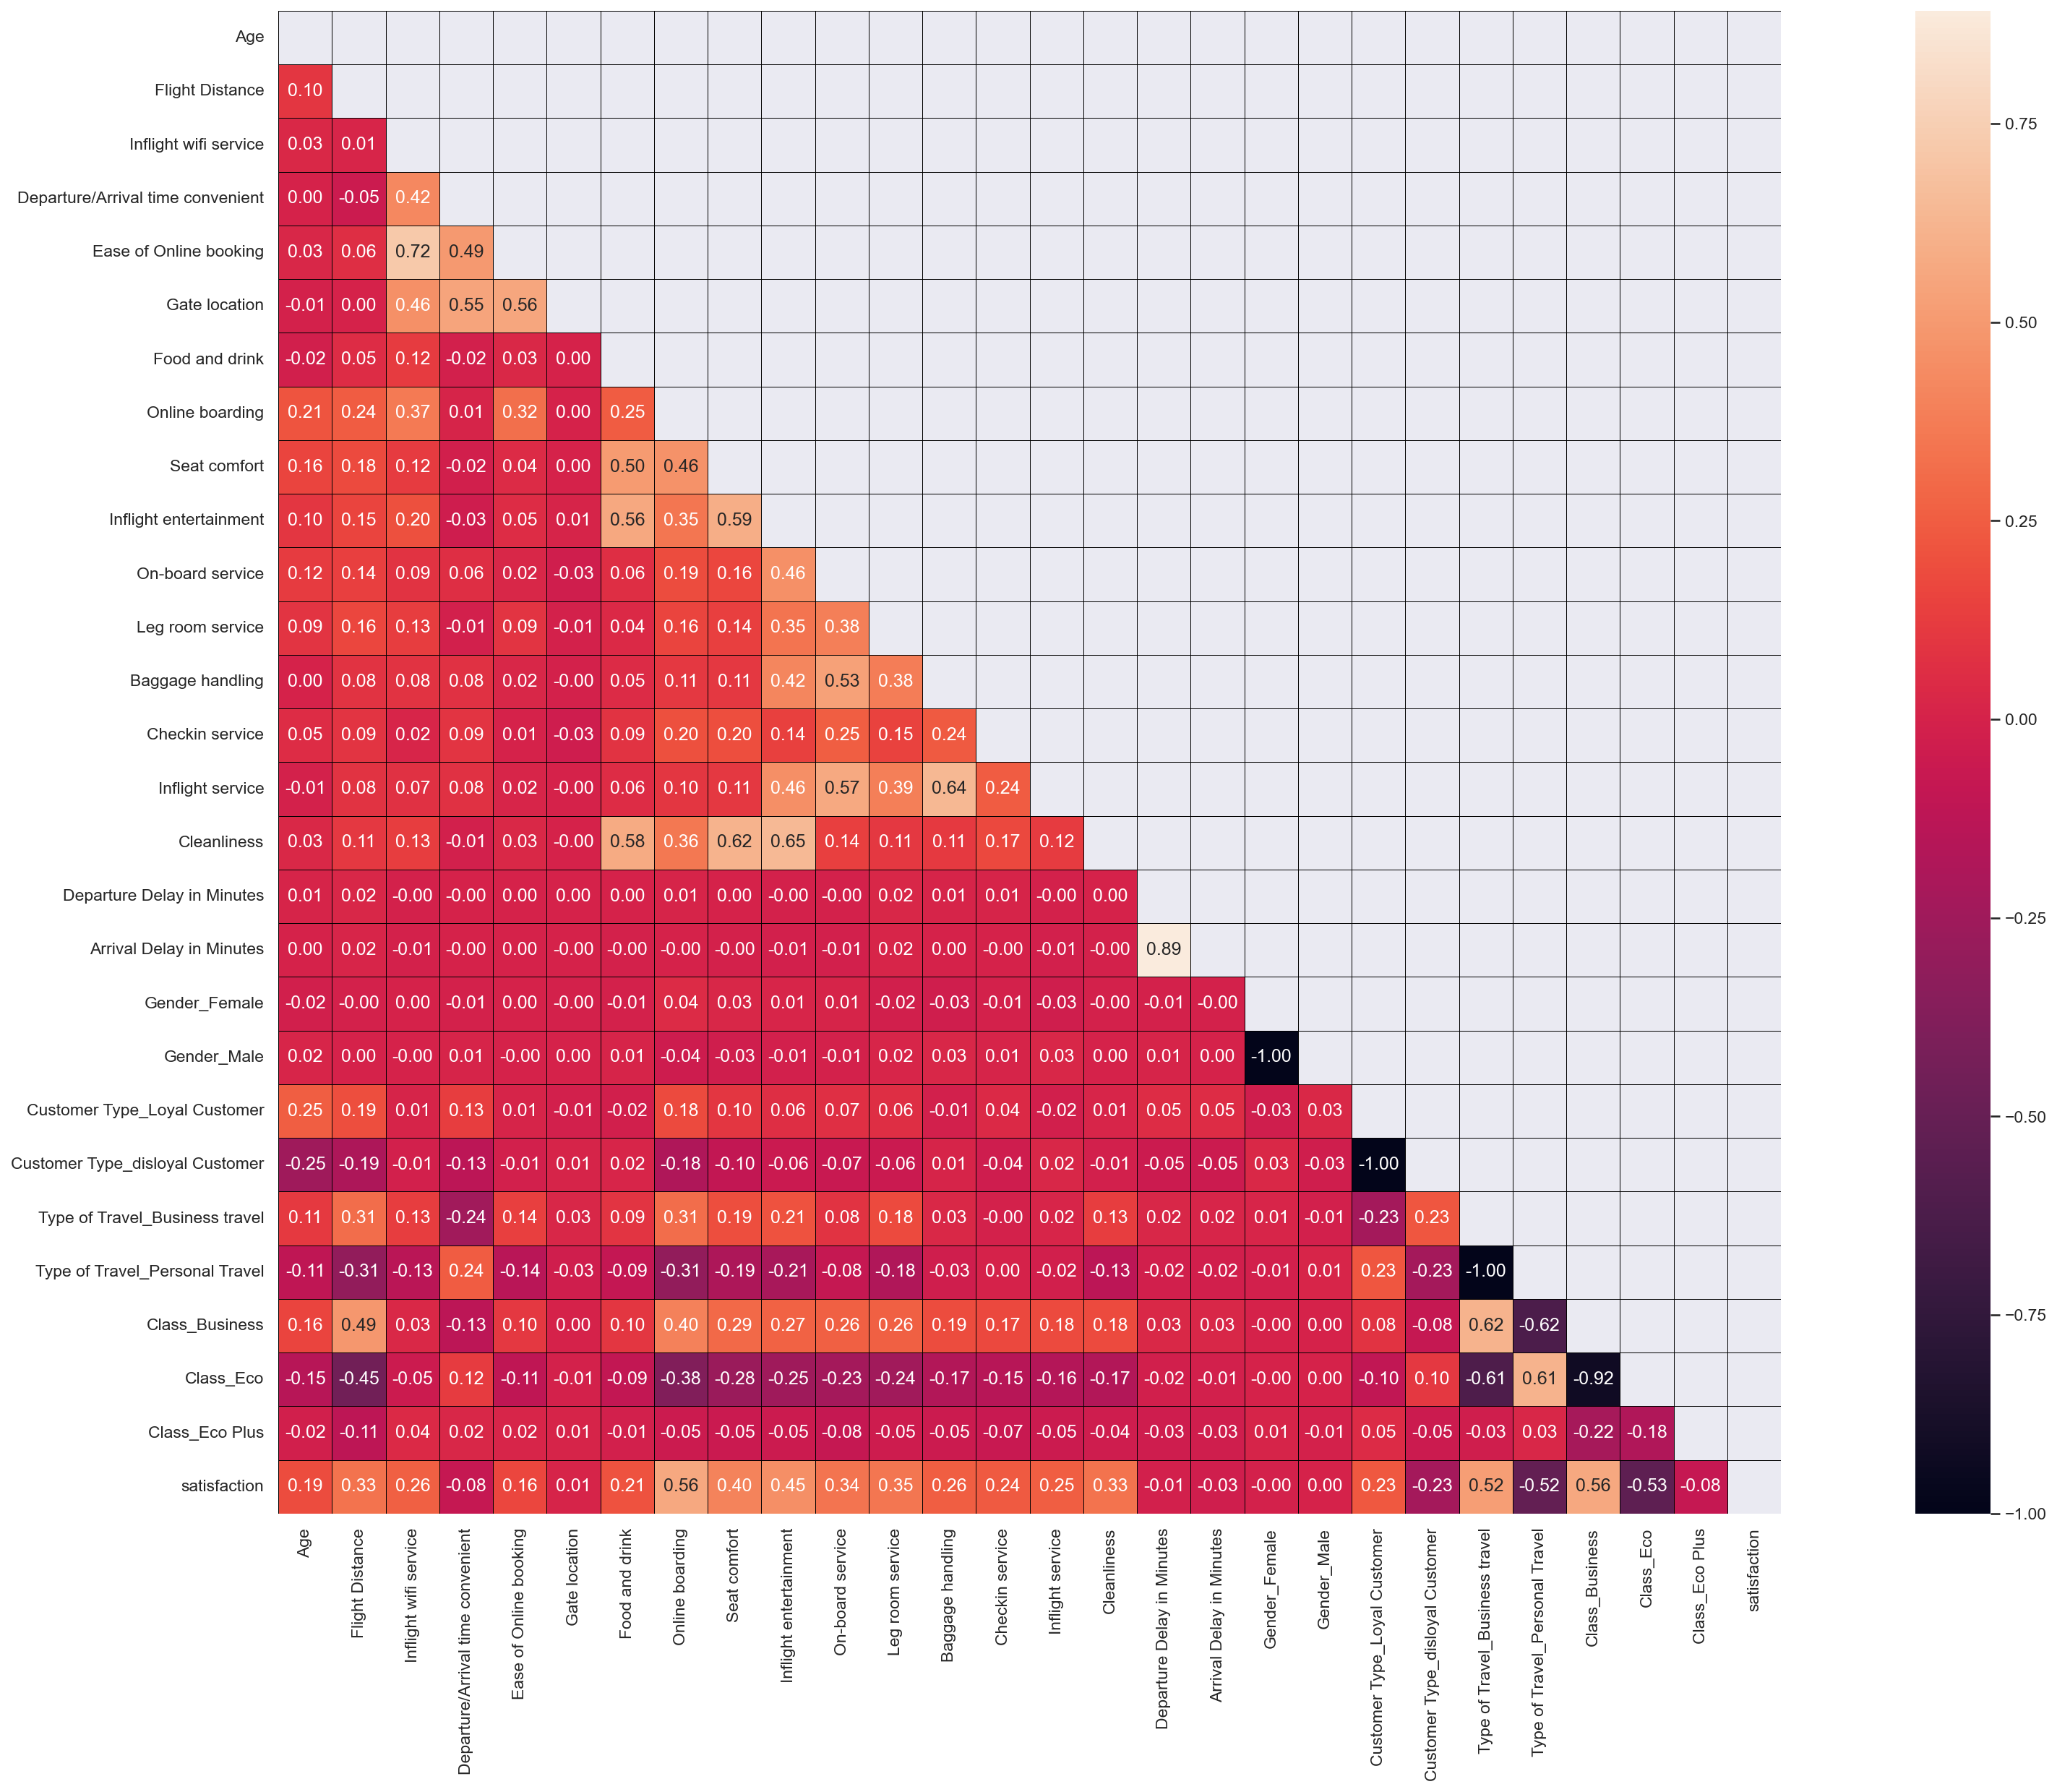

In [27]:
merged_df = pd.merge(X_train, y_train, right_index=True, left_index=True)
corr_df = merged_df.corr()
mask_corr = np.triu(np.ones_like(corr_df.corr()))
plt.figure(figsize=(32, 18), dpi=150)
sns.heatmap(data=corr_df,
            mask=mask_corr,
            square=True,
            annot=True,
            fmt=".2f",
            linewidths=0.25,
            linecolor="black")

As we can see within this matrix, there are features with very high correlation values, and therefore, they need to be removed.

It is necessary to remove them because they are redundant; in fact, a prime example is whether a passenger is male or female; in fact, we only need to know if he is Male (0 or 1) to figure out if he is Female automatically, so keeping both is redundant.

In [28]:
# Crea la matrice di correlazione
corr_matrix = merged_df.corr().abs()

# Seleziona il triangolo superiore della matrice di correlazione
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trova le caratteristiche con correlazione superiore a 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.975)]
to_drop

['Gender_Male',
 'Customer Type_disloyal Customer',
 'Type of Travel_Personal Travel']

In [29]:
for df in [X_train, X_test]:
    df = df.drop(columns=to_drop, inplace=True)

In [30]:
X_train

Age  Flight Distance  Inflight wifi service  \
0      0.153846         0.278675                    0.8   
1      0.525641         0.036753                    0.4   
2      0.474359         0.025646                    0.4   
3      0.435897         0.075323                    0.6   
4      0.525641         0.496163                    0.2   
...         ...              ...                    ...   
77521  0.294872         0.097738                    1.0   
77522  0.025641         0.568255                    0.2   
77523  0.205128         0.297456                    0.4   
77524  0.141026         0.124192                    1.0   
77525  0.615385         0.041397                    1.0   

       Departure/Arrival time convenient  Ease of Online booking  \
0                                    1.0                     0.8   
1                                    0.6                     0.6   
2                                    0.6                     0.6   
3                                    0.6                     0.6   
4                                    0.2                     0.2   
...                                  ...                     ...   
77521                                0.8                     0.8   
77522                                0.8                     0.8   
77523                                0.8                     0.8   
77524                                0.6                     0.6   
77525                                0.6                     0.6   

       Gate location  Food and drink  Online boarding  Seat comfort  \
0                1.0             0.8              0.8           0.6   
1                0.6             0.4              0.4           0.4   
2                0.6             0.4              0.4           0.4   
3                0.6             0.8              0.6           0.8   
4                0.2             0.6              0.8           0.8   
...              ...             ...              ...           ...   
77521            0.8             1.0              1.0           1.0   
77522            0.8             0.4              0.2           0.2   
77523            0.8             0.4              0.4           0.4   
77524            0.6             1.0              1.0           1.0   
77525            0.6             0.2              0.6           0.6   

       Inflight entertainment  ...  Inflight service  Cleanliness  \
0                         0.8  ...               0.8          0.8   
1                         0.4  ...               1.0          0.4   
2                         0.4  ...               0.8          0.4   
3                         0.8  ...               0.6          0.8   
4                         1.0  ...               1.0          1.0   
...                       ...  ...               ...          ...   
77521                     1.0  ...               0.6          1.0   
77522                     0.6  ...               0.4          0.2   
77523                     0.4  ...               0.8          0.4   
77524                     1.0  ...               0.8          1.0   
77525                     1.0  ...               1.0          0.6   

       Departure Delay in Minutes  Arrival Delay in Minutes  Gender_Female  \
0                        0.000628                  0.000000            1.0   
1                        0.000000                  0.000000            0.0   
2                        0.000000                  0.000000            0.0   
3                        0.005025                  0.010101            1.0   
4                        0.003769                  0.001894            0.0   
...                           ...                       ...            ...   
77521                    0.000000                  0.000000            1.0   
77522                    0.006910                  0.014520            0.0   
77523                    0.032663                  0.018308            0.0   
77524                   

In [31]:
# Creo 2 nuovi dataframe con tutte le features
X_train_all_col = X_train.copy()
X_test_all_col = X_test.copy()

## Chi2 & Anova
Through the Chi2 and Anova test I choose the top 4 features that perform best in these tests.

In [32]:
results = []
test_ls = [chi2, f_classif]
for test in test_ls:
    sel = SelectKBest(score_func=test, k=4)
    k = sel.fit(X_train, y_train)
    results.append(k)

chi2_col = sorted(results[0].get_feature_names_out())
anova_col = sorted(results[1].get_feature_names_out())

In [33]:
chi2_col

['Class_Business',
 'Class_Eco',
 'Online boarding',
 'Type of Travel_Business travel']

In [34]:
anova_col

['Class_Business',
 'Class_Eco',
 'Online boarding',
 'Type of Travel_Business travel']

In [35]:
common_col = common_items(chi2_col, anova_col)
common_col

['Online boarding',
 'Class_Eco',
 'Class_Business',
 'Type of Travel_Business travel']

As we can see, both tests selected the same features.

In [36]:
uncommon_col = uncommon_items(chi2_col, anova_col)
uncommon_col

[]

In [37]:
# At this point I compare the uncommon features
best_corr = []
if uncommon_col != []:
    for col in uncommon_col:
        # The uncommon feature with the highest correlation coeff will be kept and used
        value = corr_coeff_2col(merged_df, col, "satisfaction")
        best_corr.append(value)
        print(col, corr_coeff_2col(merged_df, col, "satisfaction").round(3))
    max_index = best_corr.index(max(best_corr))
    final_col_to_keep = common_col + [uncommon_col[max_index]]
else:
    print("The lists all have common elements")
    final_col_to_keep = common_col

The lists all have common elements


In [38]:
# Removing unnecessary features
X_train, X_test = X_train[final_col_to_keep].copy(
), X_test[final_col_to_keep].copy()
X_train

Online boarding  Class_Eco  Class_Business  \
0                  0.8        0.0             1.0   
1                  0.4        1.0             0.0   
2                  0.4        1.0             0.0   
3                  0.6        1.0             0.0   
4                  0.8        0.0             1.0   
...                ...        ...             ...   
77521              1.0        0.0             0.0   
77522              0.2        0.0             1.0   
77523              0.4        0.0             1.0   
77524              1.0        1.0             0.0   
77525              0.6        1.0             0.0   

       Type of Travel_Business travel  
0                                 1.0  
1                                 1.0  
2                                 1.0  
3                                 0.0  
4                                 1.0  
...                               ...  
77521                             1.0  
77522                             1.0  
77523                             1.0  
77524                             1.0  
77525                             1.0  

[77526 rows x 4 columns]

# Metrics

A primary metric to consider is Accuracy; in fact, this allows us to understand how our model performs in general terms.

However, this metric is inappropriate in cases where we have few True Positives or few True Negatives; in those cases, other metrics would be more appropriate.

**Precision** is the ratio **tp / (tp + fp)** where tp is the number of true positives and fp is the number of false positives. The Precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

**Recall** is the ratio **tp / (tp + fn)** where tp is the number of true positives and fn the number of false negatives. The Recall is intuitively the ability of the classifier to find all the positive samples.

**F1** score can be interpreted as a harmonic mean of the Precision and Recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of Precision and Recall to the F1 score is equal. The formula for the F1 score is: **2 * (precision * recall) / (precision + recall)**

# Model definition, training, hyperparameters tuning

At this point, we will compare three classification models, Ada Boost Classifier, Random Forest, and KNeighborsClassifier.

**AdaBoost classifier** is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on complex cases.

A **random forest** is a meta estimator that fits several decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True. Otherwise, the whole dataset is used to build each tree.

The principle behind **nearest neighbor** methods is to find a predefined number of training samples closest in the distance to the new point and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning) or vary based on the local density of points (radius-based neighbor learning). The distance can generally be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods since they “remember” their training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree).

## The training procedure will take place as follows:

1) Select 1 hyperparameter at a time from the most relevant to the least one.

2) Find the best value for the selected parameter by using RandomSearchCV.

3) Use GridSearchCV to find the best value for the given parameter in its surroundings. With this step, we can easily understand if, using RandomSearch; we reached a local minimum for the Loss function for the given estimator or if we reached the global minimum.

4) Once we find the best value for a specific hyperparameter, we need to iterate those steps until we are satisfied with our results.


In [39]:
ada1, ada2, ada_bs = AdaBoostClassifier(random_state=42), AdaBoostClassifier(
    random_state=42), AdaBoostClassifier(random_state=42)

rf1, rf2, rf_bs = RandomForestClassifier(
    random_state=42, n_jobs=-1), RandomForestClassifier(
        random_state=42, n_jobs=-1), RandomForestClassifier(random_state=42,
                                                            n_jobs=-1)

knn1, knn2, knn_bs = KNeighborsClassifier(n_jobs=-1), KNeighborsClassifier(
    n_jobs=-1), KNeighborsClassifier(n_jobs=-1)

model_bs = [ada_bs, rf_bs, knn_bs]
model1 = [ada1, rf1, knn1]
model2 = [ada2, rf2, knn2]

In [40]:
iteration = 30
SIZE = iteration
cv = 10
import_trained_models = True
load_csv = True

In [41]:
rf_param = {"max_depth": list(np.arange(1, 31, 1))}

knn_param = {"n_neighbors": list(np.arange(5, 155, 5))}
np.random.seed(42)
ada_param = {
    "learning_rate": sorted(list(set(loguniform.rvs(0.001, 1, size=SIZE))))
}

## Baseline model (outliers + 27/27 features)

Cross val score completed for AdaBoostClassifier(random_state=42)

Cross val score completed for RandomForestClassifier(n_jobs=-1, random_state=42)

Cross val score completed for KNeighborsClassifier(n_jobs=-1)

Created dataframe with results

The model with the lowest median of results was removed.
The remaining models are: ['Ada', 'Rf']
The AdaBoostClassifier(random_state=42) model will now be imported.
The AdaBoostClassifier(random_state=42) model was successfully imported.

The RandomForestClassifier(n_jobs=-1, random_state=42) model will now be imported.
The RandomForestClassifier(n_jobs=-1, random_state=42) model was successfully imported.



C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.1.1 when using version 1.0.2. This might lead to breaking code or i

Performance Ada:
 Accuracy: 0.9231
 Balanced Accuracy: 0.9214
 Precision: 0.9166
 Recall: 0.9073
 f1: 0.9119
 MAE: 0.0769


Performance Rf:
 Accuracy: 0.9602
 Balanced Accuracy: 0.9576
 Precision: 0.972
 Recall: 0.9362
 f1: 0.9538
 MAE: 0.0398




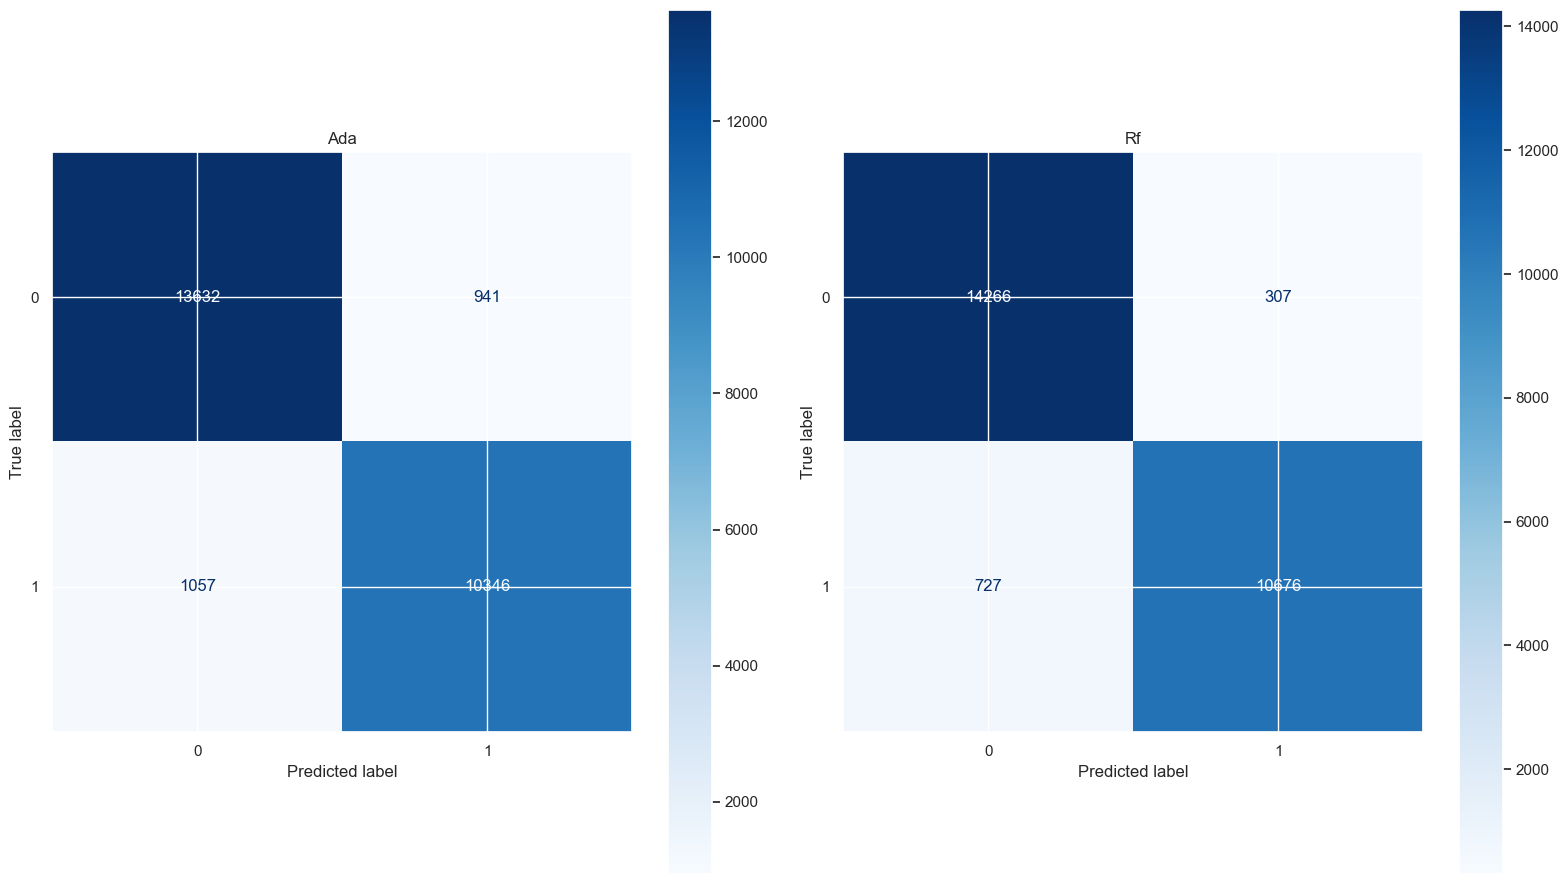

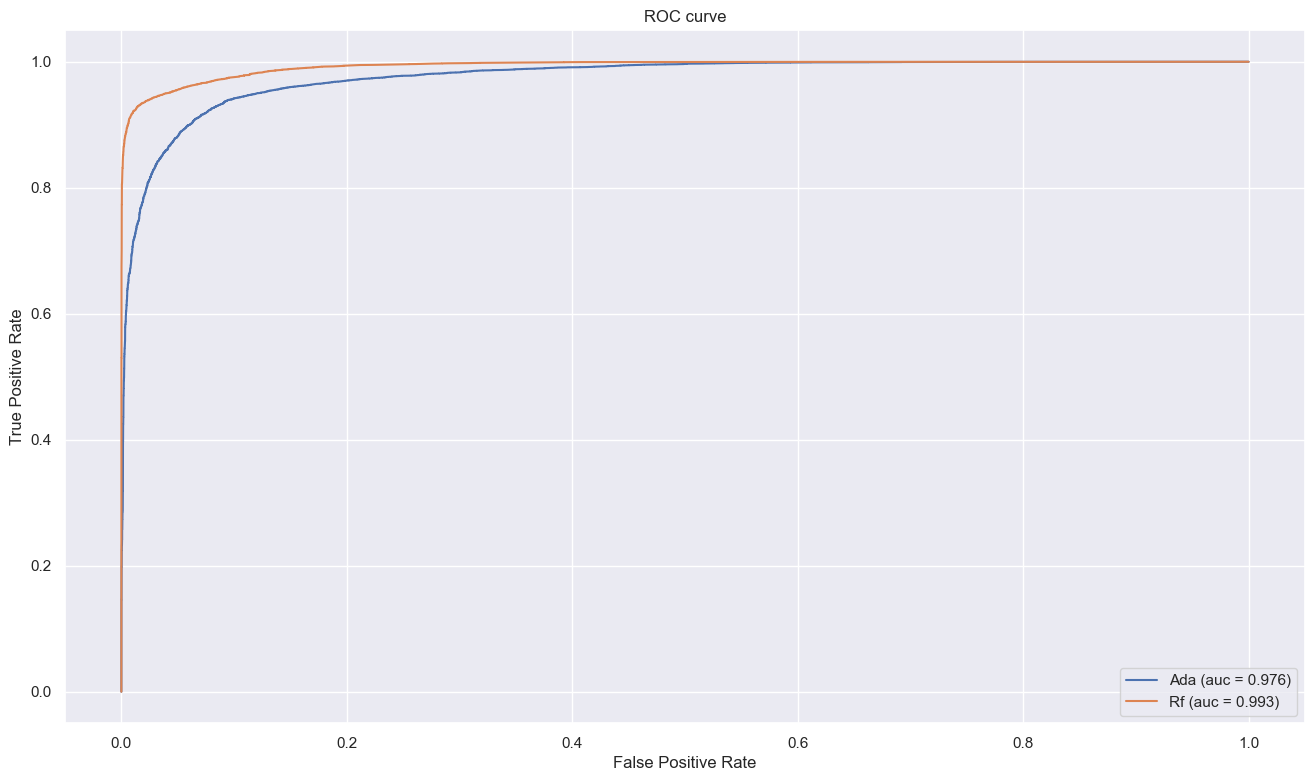

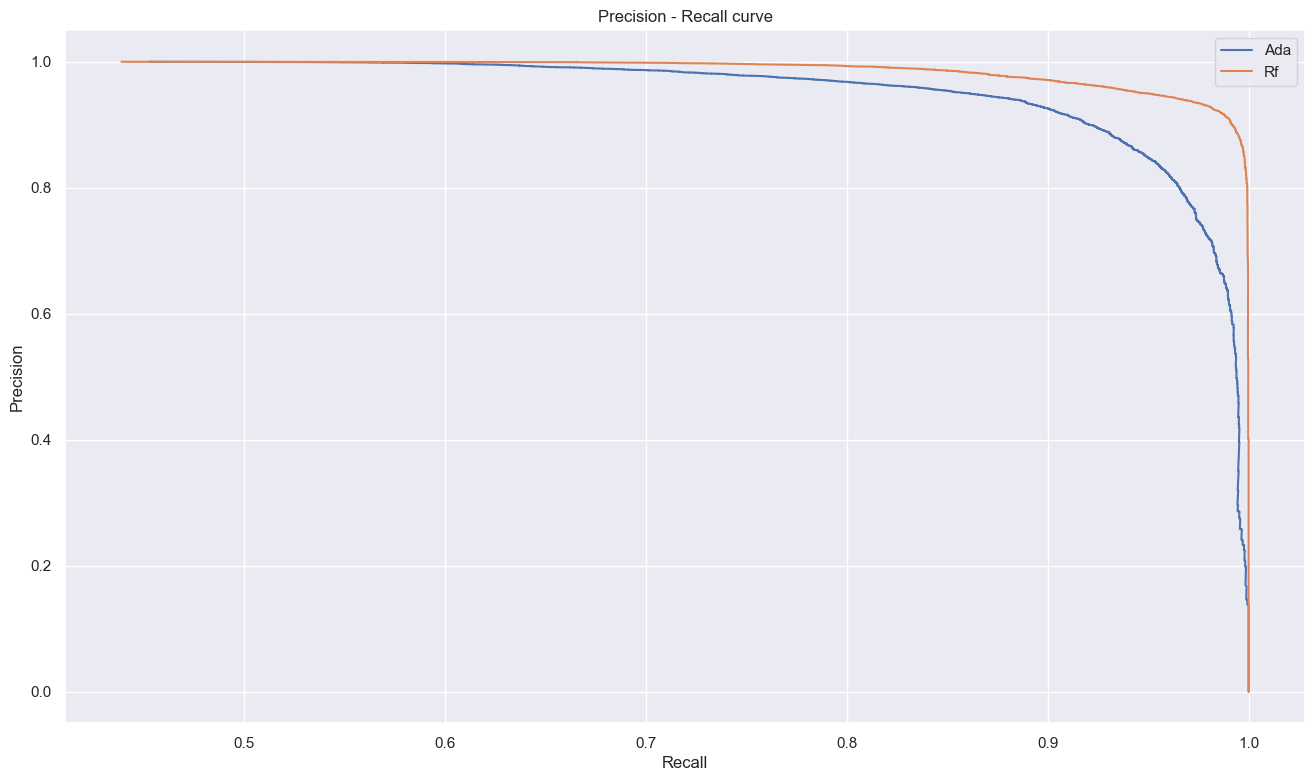

In [42]:
test1, test2 = models_evaluation(model_bs, X_train_baseline, y_train_baseline,
                                 X_test_baseline, y_test_baseline, ada_param,
                                 rf_param, knn_param, 1, import_trained_models,
                                 iteration, cv, load_csv)

## Road 1 (no-outliers & 24/27 features)

Cross val score completed for AdaBoostClassifier(random_state=42)

Cross val score completed for RandomForestClassifier(n_jobs=-1, random_state=42)

Cross val score completed for KNeighborsClassifier(n_jobs=-1)

Created dataframe with results

The model with the lowest median of results was removed.
The remaining models are: ['Rf', 'Knn']
The RandomForestClassifier(n_jobs=-1, random_state=42) model will now be imported.
The RandomForestClassifier(n_jobs=-1, random_state=42) model was successfully imported.

The KNeighborsClassifier(n_jobs=-1) model will now be imported.
The KNeighborsClassifier(n_jobs=-1) model was successfully imported.



C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.1.1 when using version 1.0.2. This might lead to breaking code 

Performance Rf:
 Accuracy: 0.9566
 Balanced Accuracy: 0.9542
 Precision: 0.9658
 Recall: 0.9342
 f1: 0.9498
 MAE: 0.0434




C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Performance Knn:
 Accuracy: 0.9173
 Balanced Accuracy: 0.9101
 Precision: 0.9566
 Recall: 0.8503
 f1: 0.9003
 MAE: 0.0827




C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


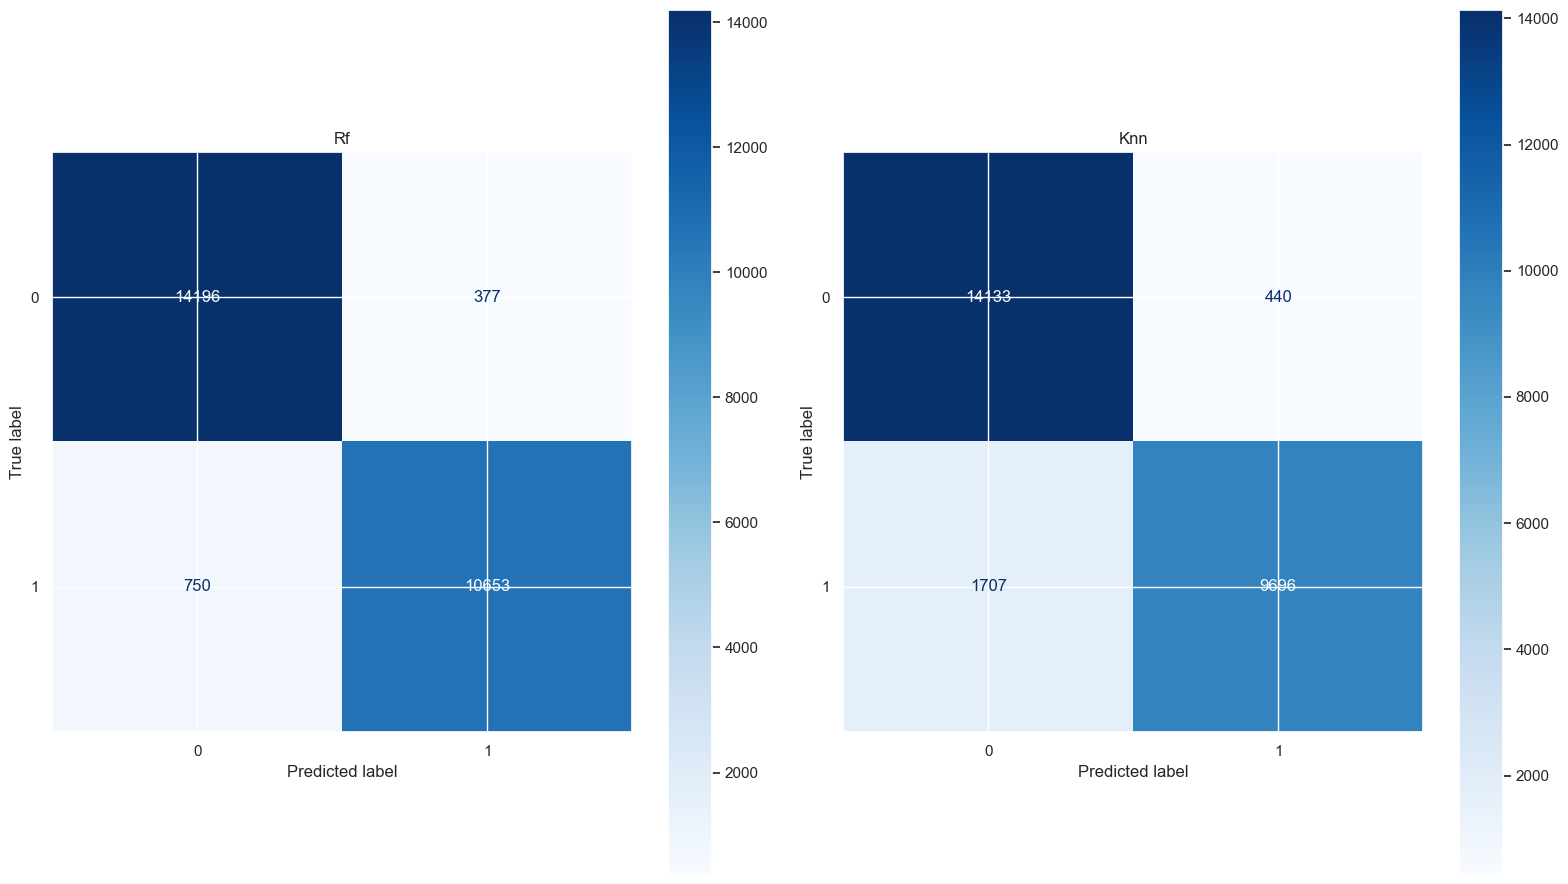

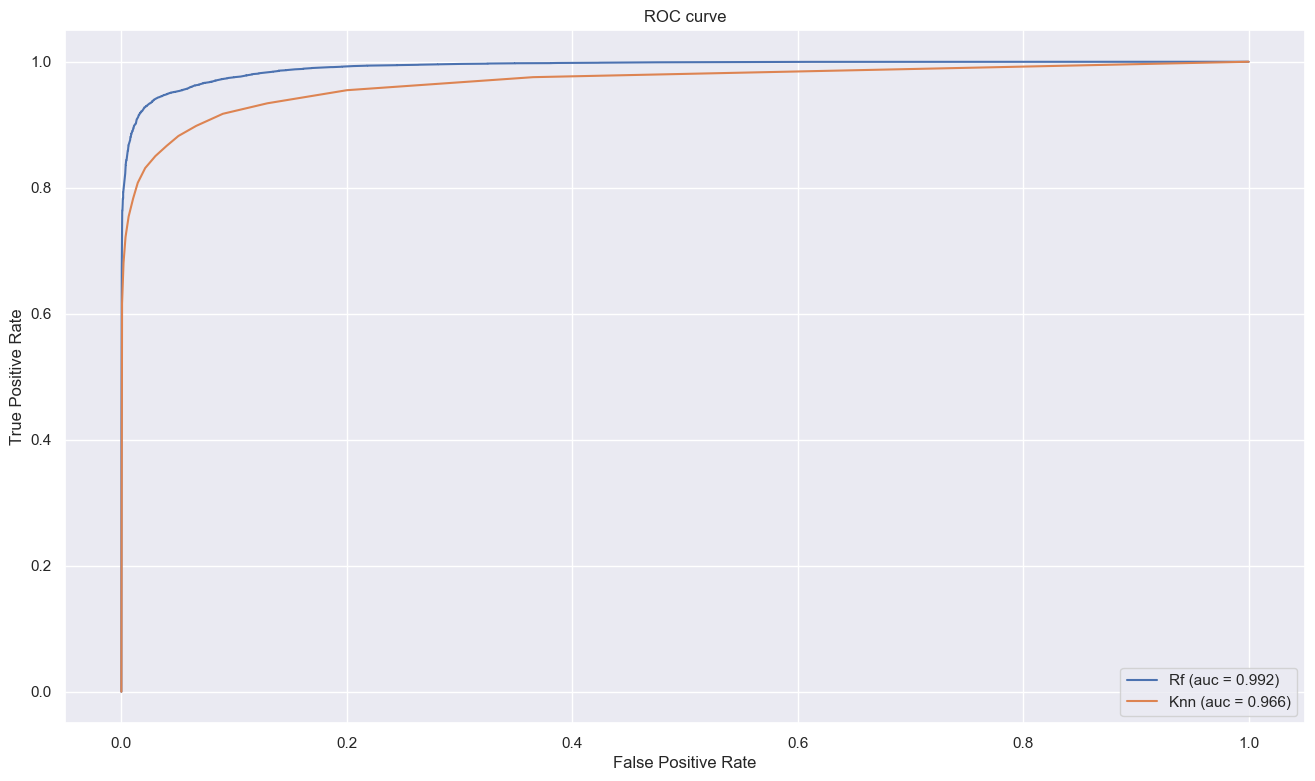

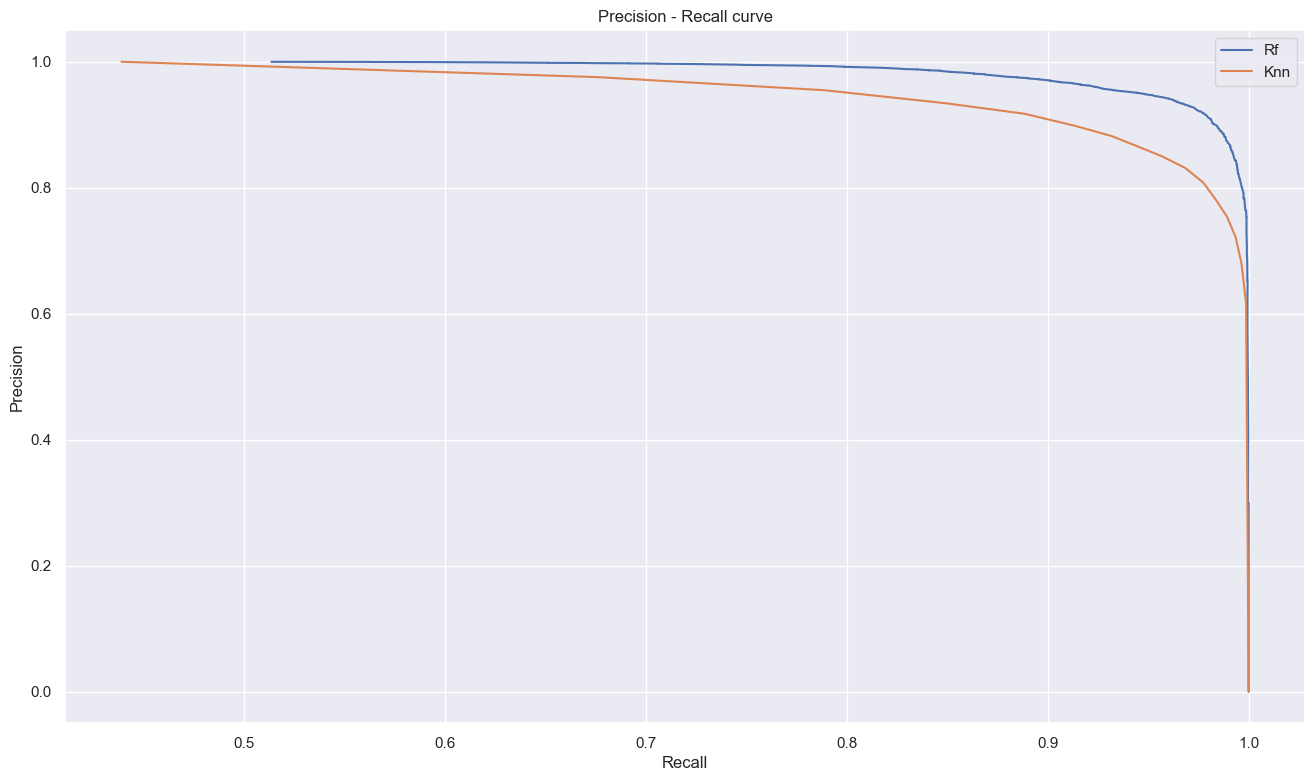

In [43]:
test3, test4 = models_evaluation(model1, X_train_all_col, y_train,
                                 X_test_all_col, y_test, ada_param, rf_param,
                                 knn_param, 2, import_trained_models,
                                 iteration, cv, load_csv)

## Road 2 (no-outliers & only 4/27 features)

Cross val score completed for AdaBoostClassifier(random_state=42)

Cross val score completed for RandomForestClassifier(n_jobs=-1, random_state=42)

Cross val score completed for KNeighborsClassifier(n_jobs=-1)

Created dataframe with results

The model with the lowest median of results was removed.
The remaining models are: ['Ada', 'Rf']
The AdaBoostClassifier(random_state=42) model will now be imported.
The AdaBoostClassifier(random_state=42) model was successfully imported.

The RandomForestClassifier(n_jobs=-1, random_state=42) model will now be imported.
The RandomForestClassifier(n_jobs=-1, random_state=42) model was successfully imported.



C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Andrea\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.1.1 when using version 1.0.2. This might lead to breaking code or i

Performance Ada:
 Accuracy: 0.8358
 Balanced Accuracy: 0.8295
 Precision: 0.8369
 Recall: 0.7775
 f1: 0.8061
 MAE: 0.1642


Performance Rf:
 Accuracy: 0.8397
 Balanced Accuracy: 0.8359
 Precision: 0.8255
 Recall: 0.8051
 f1: 0.8151
 MAE: 0.1603




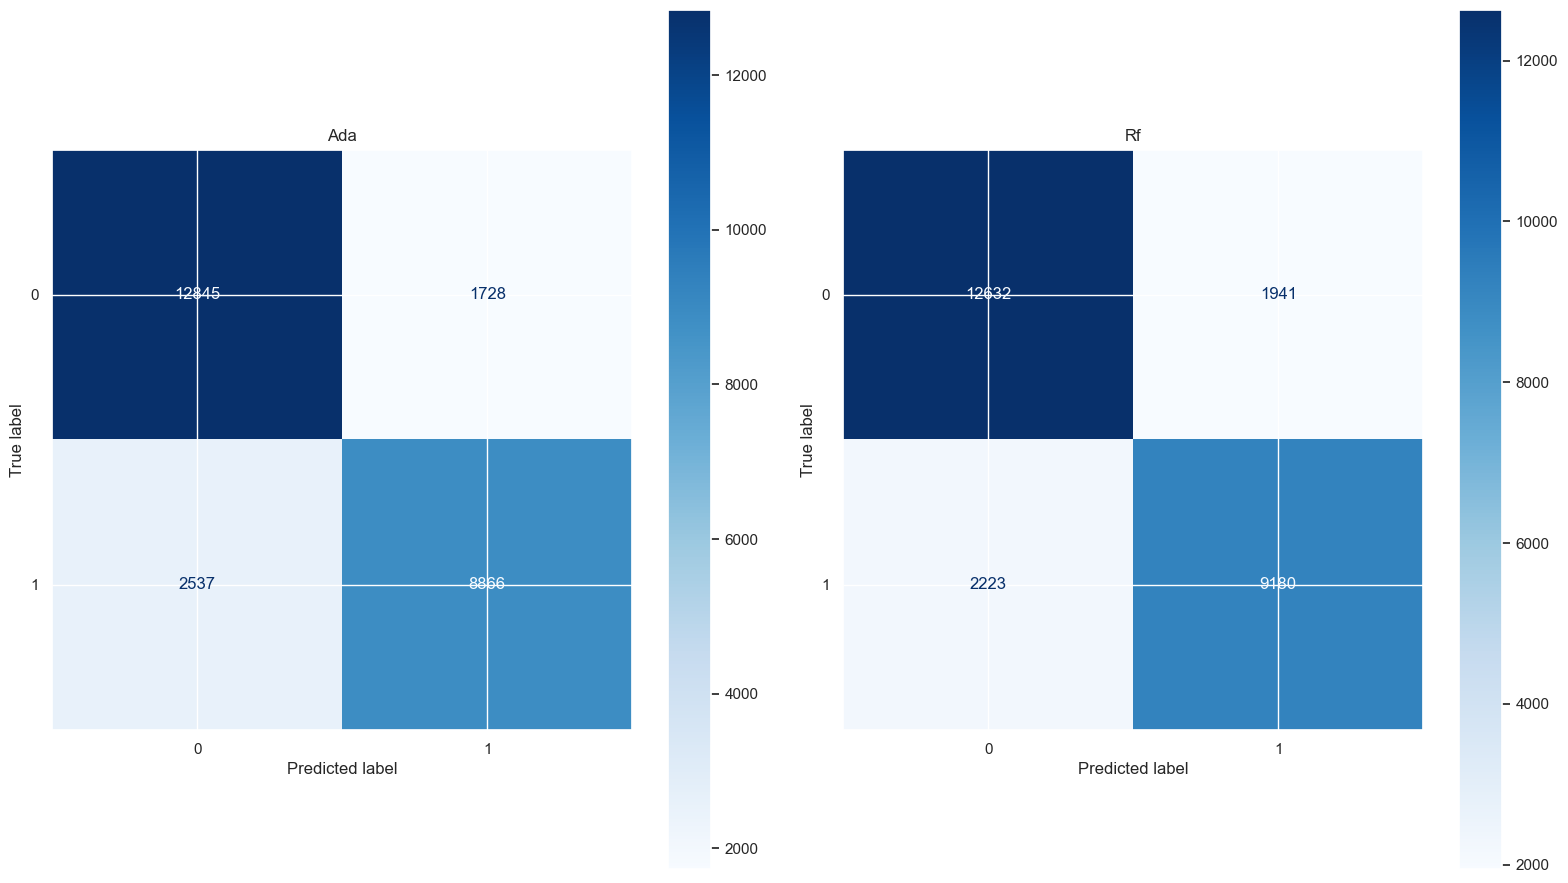

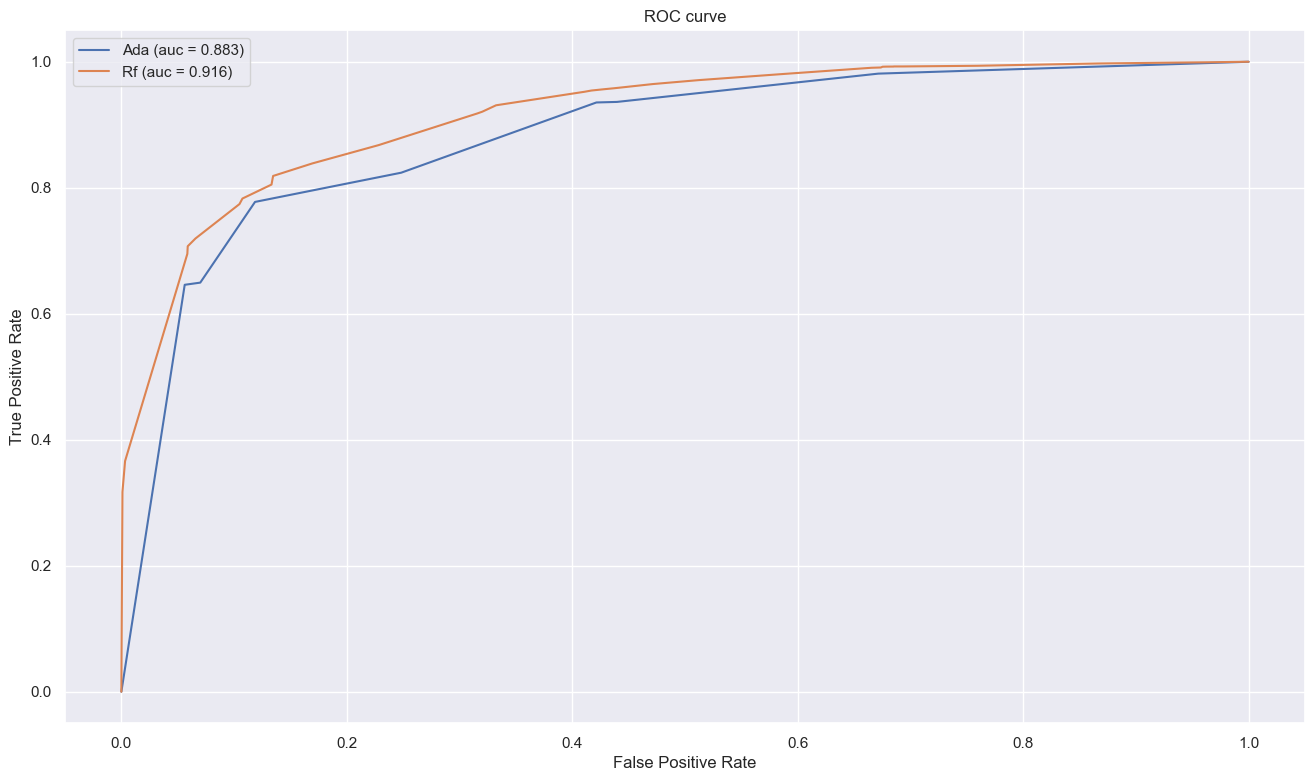

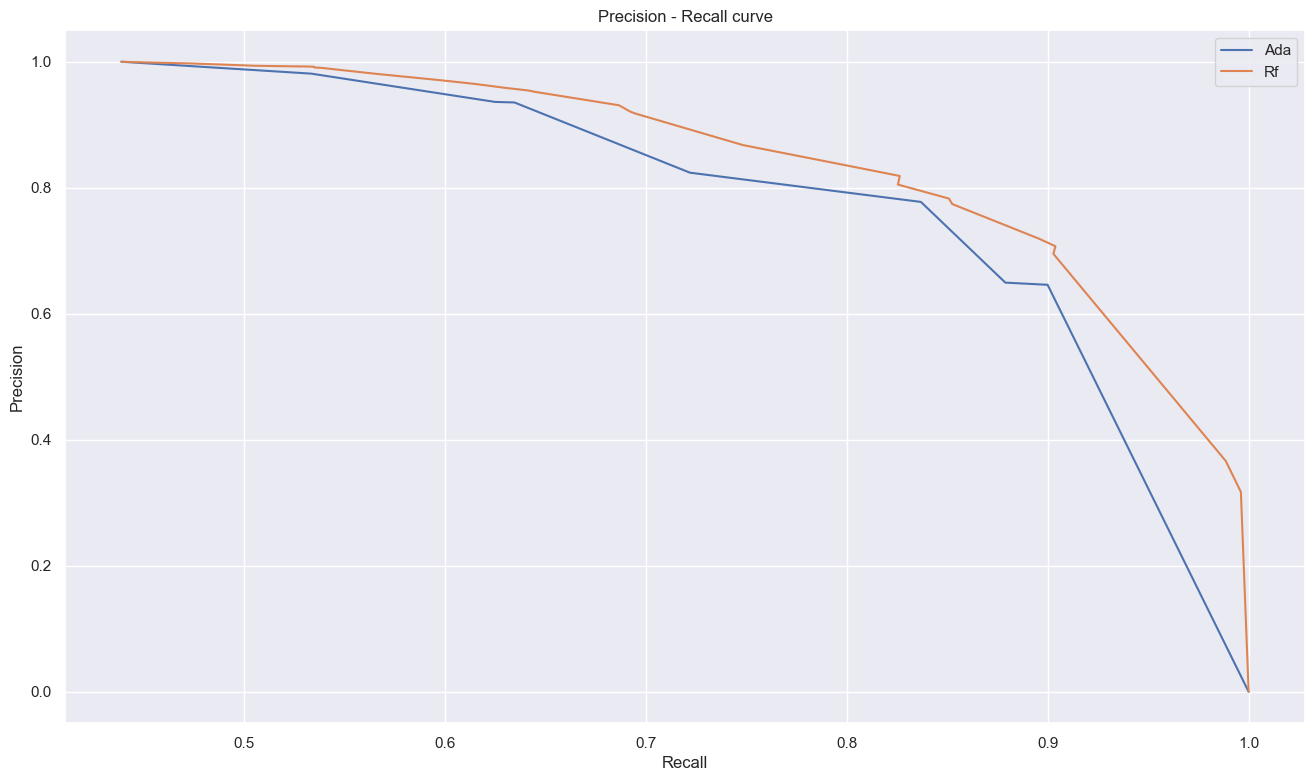

In [44]:
test5, test6 = models_evaluation(model2, X_train, y_train, X_test, y_test,
                                 ada_param, rf_param, knn_param, 3,
                                 import_trained_models, iteration, cv,
                                 load_csv)

# Considerations
Since high performance was reached by tuning only one parameter, I'd recon GridSearchCV is not needed; this procedure will take much time to obtain a few gains, which is not worth it.

Let's compare the models obtained from the three different datasets.
## Validation tests

In [45]:
best_models = []
for road in [[test1, test2], [test3, test4], [test5, test6]]:
    temp_ls = [road[0][5], road[1][5]]
    best_model = temp_ls.index(max(temp_ls))
    best_models.append(road[best_model])

In [46]:
best_baseline = pd.DataFrame(best_models[0][0])
best_road1 = pd.DataFrame(best_models[1][0])
best_road2 = pd.DataFrame(best_models[2][0])
best_results_ls = [best_baseline, best_road1, best_road2]

sorted_df = []
for df in best_results_ls:
    col_to_keep = [
        'mean_test_score', 'std_test_score', 'mean_train_score',
        'std_train_score'
    ]

    for col in df.columns:
        if col.split("_")[0] == "param":
            col_to_keep.append(col)

    df = df[col_to_keep].copy()
    df.rename(columns={
        'mean_test_score': 'mean_validation_score',
        'std_test_score': 'std_validation_score'
    },
              inplace=True)
    sorted_df.append(df)

In [47]:
names = ["Baseline", "Road1", "Road2"]
for idx, df in enumerate(sorted_df):
    df["function"] = names[idx]
merged_df = pd.concat([sorted_df[0], sorted_df[1], sorted_df[2]])

In [48]:
fig = px.line(merged_df,
              x='param_max_depth',
              y='mean_validation_score',
              color="function")
fig.show()

As we can see, if the random tree depth is greater than 5, the baseline model performs a bit better than Road1 (reduced model); this happens since the Baseline model has more data to work on and, indeed, achieve a better segmentation of the datas.

Road 2, instead, has no benefits from having a max depth greater than 4.


## Test Set

In [49]:
dfs = []
for idx, model in enumerate(best_models):
    df = pd.DataFrame([[model[5], model[6], model[7]]],
                      columns=['Acc', 'Balanced Acc', 'Mae'],
                      index=[str(model[1]).split("(")[0] + f"_{names[idx]}"])
    dfs.append(df)

final_results = pd.concat(dfs)

In [50]:
final_results

Acc  Balanced Acc     Mae
RandomForestClassifier_Baseline  0.9602        0.9576  0.0398
RandomForestClassifier_Road1     0.9566        0.9542  0.0434
RandomForestClassifier_Road2     0.8397        0.8359  0.1603

In [51]:
fig1 = px.scatter(data_frame=final_results, x=final_results.index, y="Acc")
fig1.show()

This is a plot showing model accuracy on the test set.

As we can see, Baseline and Road1 have high accuracy. This finding can be explained by the large number of features and data both models had access to, but training time on those models was way longer than Road2.

# Conclusions

In this case, the Random Forest model has a performance edge on AdaBoost and Knn; 3 out of 3 times, it came ahead in the performance comparison.

GridSearchCV was not needed for this dataset since the improvements would not have been worth the extra training time.

In this case, the baseline dataset, the one with the most information, performed the best. Feature selection, in this case, did not improve the performance. It only reduced the training time.

Precision and Recall on both Baseline and Road1 were high.

The trained models obtained from this project can predict, with really high accuracy, the outcome of a passenger review.

The Road2 model, even though it did not perform as well as the other, gave us precious insight into the most critical aspects for a passenger.

For even better performance, we could optimize the models on other hyperparameters.
